### Importing libraries

In [99]:
import pandas as pd
import numpy as np
import calendar
from datetime import datetime
import matplotlib.pyplot as plt
import missingno as msno
from plotly import express as px
import seaborn as sns

pd.set_option('display.max_columns', None)

from imblearn.combine import SMOTEENN

# %pip install tensorflow
import tensorflow as tf
from tensorflow.keras import regularizers

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

#### Reading dataset from local storage

In [100]:
hotel_booking_1 = pd.read_csv("H1.csv"); hotel_booking_2 = pd.read_csv("H2.csv")
df = pd.concat([hotel_booking_1, hotel_booking_2], axis=0).reset_index(drop=True)

In [101]:
df.shape

(119390, 31)

In [102]:
# Select categorical columns
cat_columns = df.select_dtypes(include=['object']).columns

# Select numerical columns
num_columns = df.select_dtypes(include=['number']).columns

cat_columns.shape, num_columns.shape

((13,), (18,))

##### View the top 2 rows of the dataset

In [103]:
df.head(2)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01


##### To Check and remove the duplicate records

In [104]:
df.duplicated().sum()

31994

In [105]:
df.drop_duplicates(inplace=True)
print('Sum of duplicated records:',df.duplicated().sum())
print('Shape of the dataset:',df.shape)

Sum of duplicated records: 0
Shape of the dataset: (87396, 31)


##### To check the presence of null values in the dataset

In [106]:
null_values =100 *(df.isna().sum() /df.shape[0])
null_values = null_values[null_values > 0]
null_values

Children    0.004577
Country     0.517186
dtype: float64

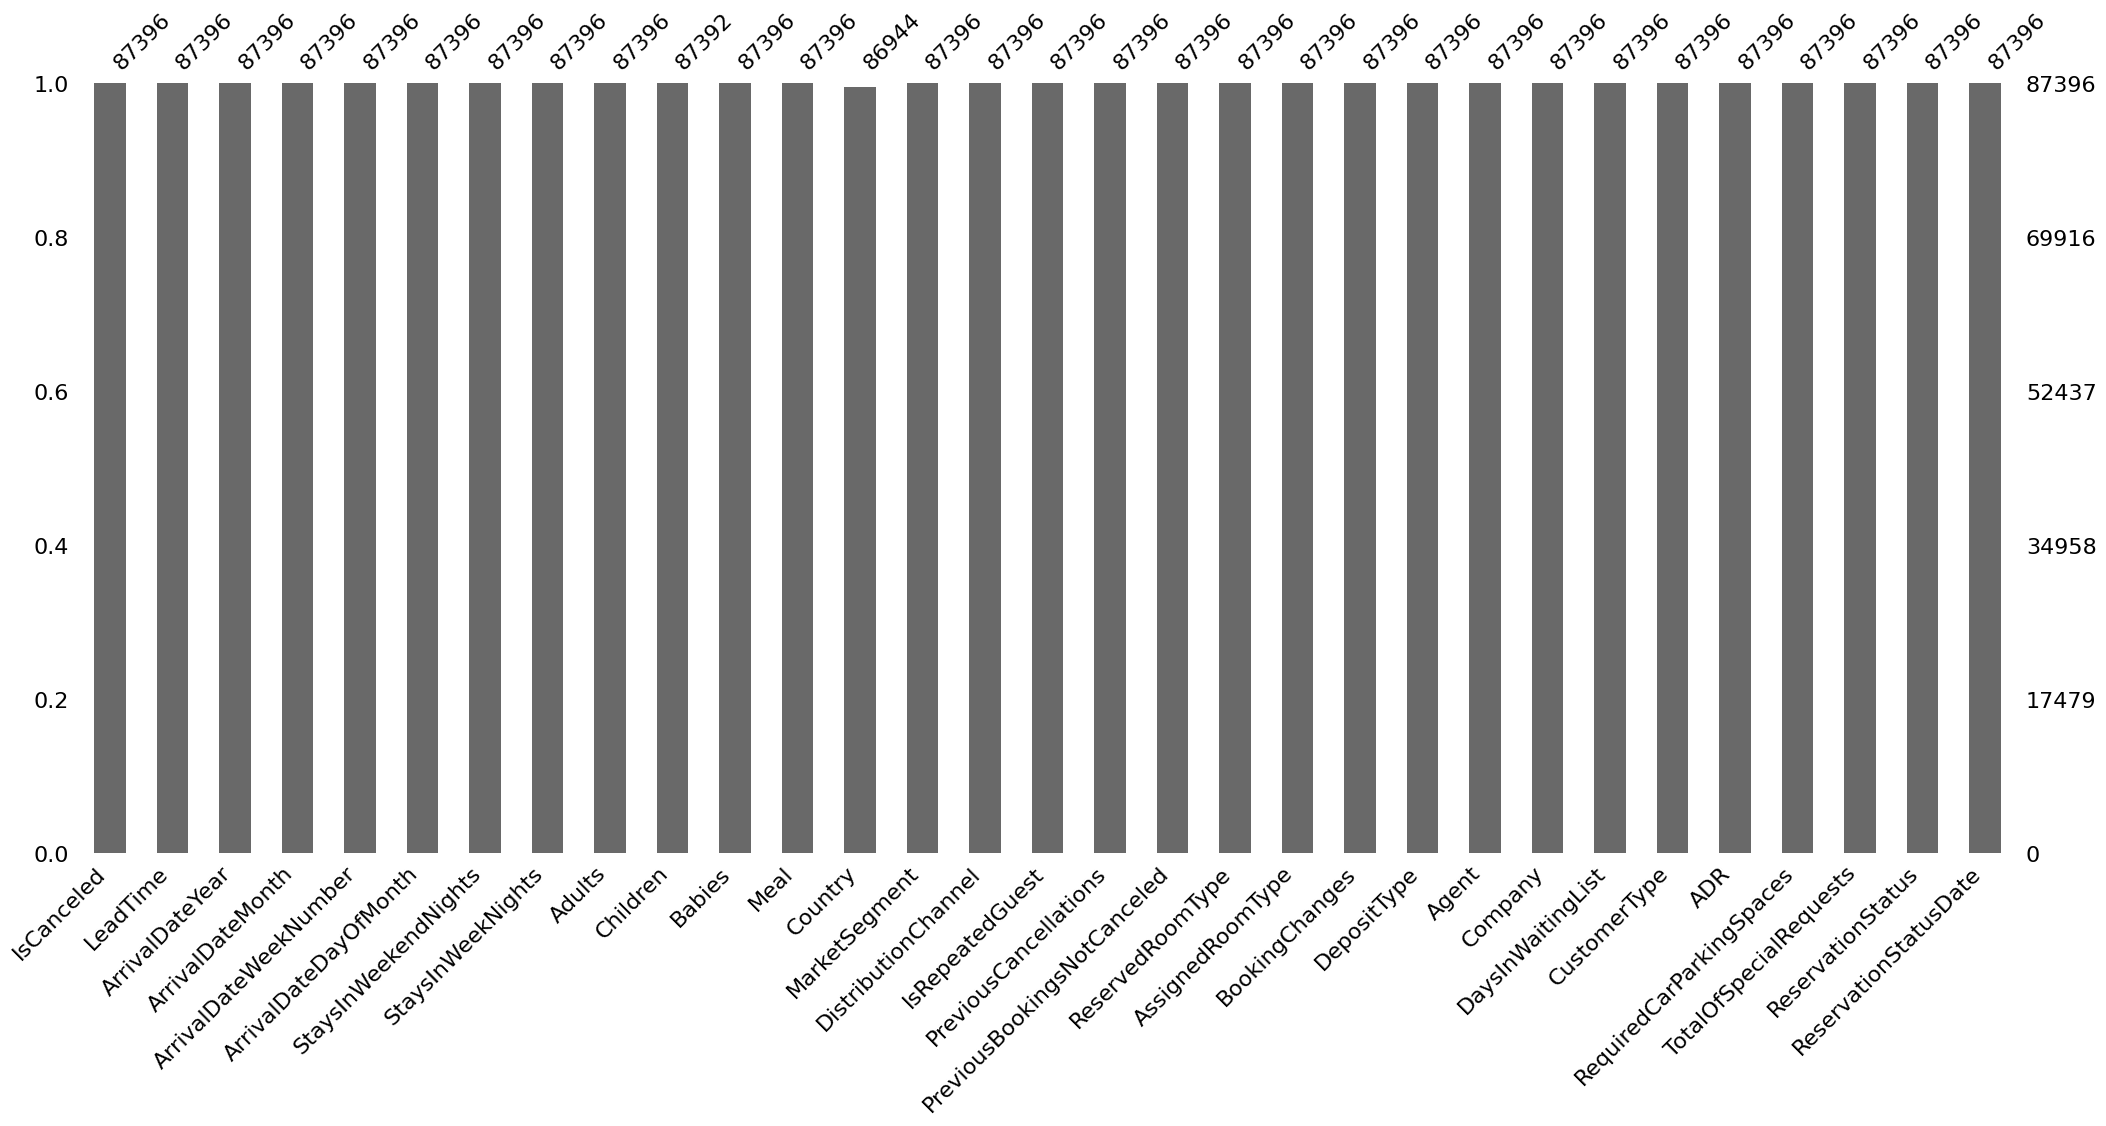

In [107]:
msno.bar(df)
plt.show()

From the about count plot we can see that the Country and Children columns have missing values

#### Removing the records having 0 occupant

In [108]:
print('Children Unique Values', df['Children'].unique())

Children Unique Values [ 0.  1.  2. 10.  3. nan]


In [109]:
df['Children'] = df['Children'].fillna(0)
df['Children'] = df['Children'].astype(int)
print('Children Unique Values', df['Children'].unique())
print('Babies Unique Values', df['Babies'].unique())
print('Adults Unique Values', df['Adults'].unique())

Children Unique Values [ 0  1  2 10  3]
Babies Unique Values [ 0  1  2 10  9]
Adults Unique Values [ 2  1  3  4 40 26 50 27 55  0 20  6  5 10]


In [110]:
filter = (df.Children == 0) & (df.Adults == 0) & (df.Babies == 0)
df[filter]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
2224,0,1,2015,October,41,6,0,3,0,0,0,SC,PRT,Corporate,Corporate,0,0,0,A,I,1,No Deposit,NULL,174,0,Transient-Party,0.00,0,0,Check-Out,2015-10-06
2409,0,0,2015,October,42,12,0,0,0,0,0,SC,PRT,Corporate,Corporate,0,0,0,A,I,0,No Deposit,NULL,174,0,Transient,0.00,0,0,Check-Out,2015-10-12
3181,0,36,2015,November,47,20,1,2,0,0,0,SC,ESP,Groups,TA/TO,0,0,0,A,C,0,No Deposit,38,NULL,0,Transient-Party,0.00,0,0,Check-Out,2015-11-23
3684,0,165,2015,December,53,30,1,4,0,0,0,SC,PRT,Groups,TA/TO,0,0,0,A,A,1,No Deposit,308,NULL,122,Transient-Party,0.00,0,0,Check-Out,2016-01-04
3708,0,165,2015,December,53,30,2,4,0,0,0,SC,PRT,Groups,TA/TO,0,0,0,A,C,1,No Deposit,308,NULL,122,Transient-Party,0.00,0,0,Check-Out,2016-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115029,0,107,2017,June,26,27,0,3,0,0,0,BB,CHE,Online TA,TA/TO,0,0,0,A,A,1,No Deposit,7,NULL,0,Transient,100.80,0,0,Check-Out,2017-06-30
115091,0,1,2017,June,26,30,0,1,0,0,0,SC,PRT,Complementary,Direct,0,0,0,E,K,0,No Deposit,NULL,NULL,0,Transient,0.00,1,1,Check-Out,2017-07-01
116251,0,44,2017,July,28,15,1,1,0,0,0,SC,SWE,Online TA,TA/TO,0,0,0,A,K,2,No Deposit,425,NULL,0,Transient,73.80,0,0,Check-Out,2017-07-17
116534,0,2,2017,July,28,15,2,5,0,0,0,SC,RUS,Online TA,TA/TO,0,0,0,A,K,1,No Deposit,9,NULL,0,Transient-Party,22.86,0,1,Check-Out,2017-07-22


In [111]:
# removing invalid records
df = df[~filter]
df[filter]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate


In [112]:
df.shape

(87230, 31)

In [113]:
df['Country'].nunique()

177

##### Finding the Total number of guest related to each country

In [114]:
#From where the most guest are coming, displaying top 10 countries
guest_city = df['Country'].value_counts().reset_index()
guest_city.columns = ['Country', 'Total No of guests booked reservation']
guest_city.head(10)

,Country,Total No of guests booked reservation
0,PRT,27355
1,GBR,10424
2,FRA,8823
3,ESP,7244
4,DEU,5385
5,ITA,3061
6,IRL,3015
7,BEL,2081
8,BRA,1993
9,NLD,1910


In [115]:
#From where the most guest cancel there bookings, displaying top 10 countries
guest_city1 = df[df['IsCanceled'] == 1]['Country'].value_counts().reset_index()
guest_city1.columns = ['Country', 'No of guests Canceled the reservation']
guest_city1.head(10)

,Country,No of guests Canceled the reservation
0,PRT,9782
1,GBR,1984
2,ESP,1862
3,FRA,1732
4,ITA,1075
5,DEU,1053
6,BRA,727
7,IRL,668
8,USA,459
9,BEL,411


In [116]:
# Group by 'Country' and calculate total records and canceled records
df_grouped = df.groupby('Country').agg(
    TotalRecords=('IsCanceled', 'count'),
    CanceledRecords=('IsCanceled', 'sum')
).reset_index()

# Create new columns for plotting
df_grouped['NotCanceledRecords'] = df_grouped['TotalRecords'] - df_grouped['CanceledRecords']

# Sort by 'TotalRecords' in descending order and select top 10 countries
df_top10 = df_grouped.sort_values(by='TotalRecords', ascending=False).head(10)


# Create bar plot
fig = px.bar(df_top10.head(10), 
             x='Country', 
             y=['CanceledRecords', 'NotCanceledRecords'], 
             title='Canceled vs Not Canceled Records by Country',
             labels={'value': 'Number of Records', 'variable': 'Status'},
             barmode='stack')

# Update layout
fig.update_layout(xaxis_title='Country',
                  yaxis_title='Number of Records',
                  legend_title='Status')

# Show plot
fig.show()

In [117]:
fig = px.choropleth(guest_city, 
                    locations="Country",
                    color="Total No of guests booked reservation",
                    hover_name="Country",
                    projection="natural earth",
                    title="Number of Guests by Country")

# Set the height and width of the figure
fig.update_layout(height=600, width=1000)

fig.show()

In [118]:
# Select categorical columns
cat_columns = df.select_dtypes(include=['object']).columns

# Select numerical columns
num_columns = df.select_dtypes(include=['number']).columns

cat_columns, num_columns

(Index(['ArrivalDateMonth', 'Meal', 'Country', 'MarketSegment',
        'DistributionChannel', 'ReservedRoomType', 'AssignedRoomType',
        'DepositType', 'Agent', 'Company', 'CustomerType', 'ReservationStatus',
        'ReservationStatusDate'],
       dtype='object'),
 Index(['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateWeekNumber',
        'ArrivalDateDayOfMonth', 'StaysInWeekendNights', 'StaysInWeekNights',
        'Adults', 'Children', 'Babies', 'IsRepeatedGuest',
        'PreviousCancellations', 'PreviousBookingsNotCanceled',
        'BookingChanges', 'DaysInWaitingList', 'ADR',
        'RequiredCarParkingSpaces', 'TotalOfSpecialRequests'],
       dtype='object'))

In [119]:
# count of uniques values in a column
for i in cat_columns:
    print(i,':',df[i].nunique())

ArrivalDateMonth : 12
Meal : 5
Country : 177
MarketSegment : 8
DistributionChannel : 5
ReservedRoomType : 9
AssignedRoomType : 11
DepositType : 3
Agent : 334
Company : 349
CustomerType : 4
ReservationStatus : 3
ReservationStatusDate : 926


##### Droping the columns which are not required

In [120]:
df.drop(['Country'], axis=1, inplace=True)

In [121]:
print(df['Agent'].groupby(df['Agent']).count().sort_values(ascending=False).head(10))
df.drop(['Agent'], axis=1, inplace=True)

Agent
          9    28721
        240    13028
       NULL    12141
         14     3342
          7     3294
        250     2779
        241     1644
         28     1493
          8     1383
          1     1228
Name: Agent, dtype: int64


In [122]:
print(df['Company'].groupby(df['Company']).count().sort_values(ascending=False).head(10))
df.drop(['Company'], axis=1, inplace=True)

Company
       NULL    81993
         40      848
        223      503
         45      237
        153      205
        154      133
        219      131
        174      119
        281      119
        233       94
Name: Company, dtype: int64


In [123]:
df['ReservationStatusDate'] = pd.to_datetime(df['ReservationStatusDate'])
df['ReservationStatus_Year'] = df['ReservationStatusDate'].dt.year
df['ReservationStatus_Month'] = df['ReservationStatusDate'].dt.month
df['ReservationStatus_Day_Number'] = df['ReservationStatusDate'].dt.day
df['ReservationStatus_Day'] = df['ReservationStatusDate'].dt.day_name()

df.drop('ReservationStatusDate', axis=1, inplace=True)

print(df['ReservationStatus_Year'].unique()); 
print(df['ReservationStatus_Month'].unique()); 
print(df['ReservationStatus_Day'].unique())

[2015 2014 2016 2017]
[ 7  5  4  6  3  8  9  1 11 10 12  2]
['Wednesday' 'Thursday' 'Friday' 'Tuesday' 'Sunday' 'Monday' 'Saturday']


In [124]:
cat_columns = df.select_dtypes(include=['object']).columns

# uniques values in a column
for i in cat_columns:
    print(i,':',df[i].unique())

ArrivalDateMonth : ['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
Meal : ['BB       ' 'FB       ' 'HB       ' 'SC       ' 'Undefined']
MarketSegment : ['Direct' 'Corporate' 'Online TA' 'Offline TA/TO' 'Complementary' 'Groups'
 'Undefined' 'Aviation']
DistributionChannel : ['Direct' 'Corporate' 'TA/TO' 'Undefined' 'GDS']
ReservedRoomType : ['C               ' 'A               ' 'D               '
 'E               ' 'G               ' 'F               '
 'H               ' 'L               ' 'B               ']
AssignedRoomType : ['C               ' 'A               ' 'D               '
 'E               ' 'G               ' 'F               '
 'I               ' 'B               ' 'H               '
 'L               ' 'K               ']
DepositType : ['No Deposit     ' 'Refundable     ' 'Non Refund     ']
CustomerType : ['Transient' 'Contract' 'Transient-Party' 'Group']
ReservationStatus : ['Check-Out' 'Canceled' 'No-S

In [125]:
for i in cat_columns:
    df[i] = df[i].apply(lambda x: x.strip() if isinstance(x, str) else x)

In [126]:
df['ReservationStatus_Year'].groupby(df['ReservationStatus_Year']).count()

ReservationStatus_Year
2014       12
2015    13519
2016    43850
2017    29849
Name: ReservationStatus_Year, dtype: int64

In [127]:
loc = df[df['ReservationStatus_Year'] == 2014].index
df.drop(loc, inplace=True)

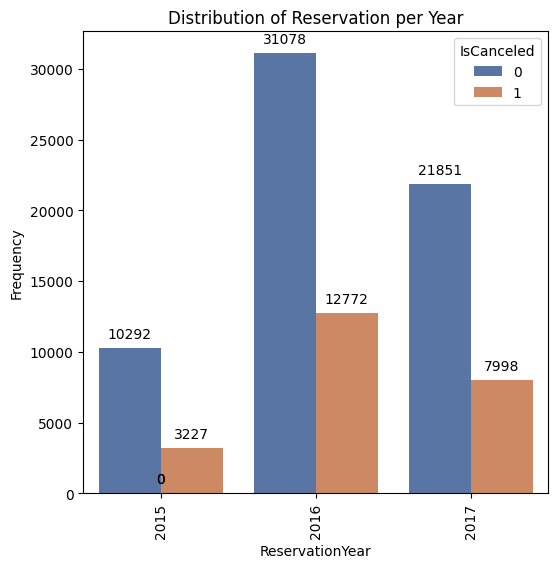

In [128]:
# Create a bar plot using seaborn
plt.figure(figsize=(6, 6))  
ax = sns.countplot(data=df, x='ReservationStatus_Year', palette='deep', hue= 'IsCanceled')

# Add labels and title
plt.xlabel('ReservationYear')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.title('Distribution of Reservation per Year')

# Annotate each bar with its count
for p in ax.patches:
    height = int(p.get_height())  # Convert height to integer
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Show the plot
plt.show()

In [129]:
df['Meal'].groupby(df['Meal']).count().sort_values(ascending=False).head(10)

Meal
BB           67895
SC            9391
HB            9080
Undefined      492
FB             360
Name: Meal, dtype: int64

In [130]:
df['Meal'].replace('Other', 'SC', inplace=True)
df['Meal'].groupby(df['Meal']).count().sort_values(ascending=False).head(10)

Meal
BB           67895
SC            9391
HB            9080
Undefined      492
FB             360
Name: Meal, dtype: int64

In [131]:
df['MarketSegment'].groupby(df['MarketSegment']).count().sort_values(ascending=False).head(10)

MarketSegment
Online TA        51553
Offline TA/TO    13855
Direct           11779
Groups            4911
Corporate         4200
Complementary      692
Aviation           226
Undefined            2
Name: MarketSegment, dtype: int64

In [132]:
index = df[df['MarketSegment'] == 'Undefined'].index
df.drop(index, inplace=True)

In [133]:
# Select categorical columns
cat_columns = df.select_dtypes(include=['object']).columns

# Select numerical columns
num_columns = df.select_dtypes(include=['number']).columns

cat_columns, num_columns

(Index(['ArrivalDateMonth', 'Meal', 'MarketSegment', 'DistributionChannel',
        'ReservedRoomType', 'AssignedRoomType', 'DepositType', 'CustomerType',
        'ReservationStatus', 'ReservationStatus_Day'],
       dtype='object'),
 Index(['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateWeekNumber',
        'ArrivalDateDayOfMonth', 'StaysInWeekendNights', 'StaysInWeekNights',
        'Adults', 'Children', 'Babies', 'IsRepeatedGuest',
        'PreviousCancellations', 'PreviousBookingsNotCanceled',
        'BookingChanges', 'DaysInWaitingList', 'ADR',
        'RequiredCarParkingSpaces', 'TotalOfSpecialRequests',
        'ReservationStatus_Year', 'ReservationStatus_Month',
        'ReservationStatus_Day_Number'],
       dtype='object'))

In [134]:
# Define a lambda function to convert month names to month numbers
month_to_number = lambda x: pd.to_datetime(x, format='%B').month

# Apply the lambda function to the 'Month' column to convert month names to month numbers
df['ArrivalDateMonth'] = df['ArrivalDateMonth'].apply(month_to_number)

df['ArrivalDateMonth'].unique()

array([ 7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6], dtype=int64)

In [135]:
cat_columns = df.select_dtypes(include=['object']).columns
cat_columns

Index(['Meal', 'MarketSegment', 'DistributionChannel', 'ReservedRoomType',
       'AssignedRoomType', 'DepositType', 'CustomerType', 'ReservationStatus',
       'ReservationStatus_Day'],
      dtype='object')

In [136]:
for i in cat_columns:
    print(i,':',df[i].nunique())

Meal : 5
MarketSegment : 7
DistributionChannel : 5
ReservedRoomType : 9
AssignedRoomType : 11
DepositType : 3
CustomerType : 4
ReservationStatus : 3
ReservationStatus_Day : 7


Text(0.5, 1.0, 'Arriving year, Lead time and Cancelations')

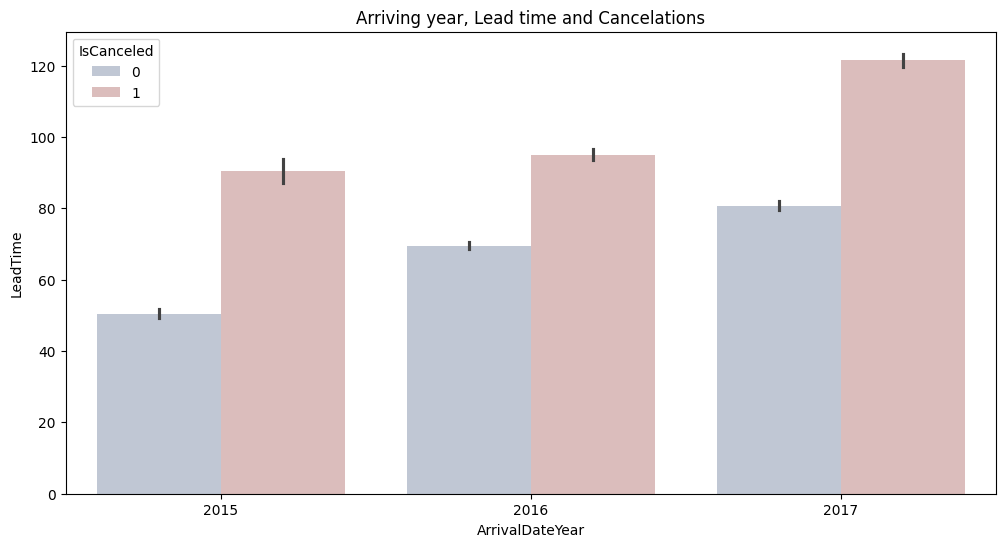

In [137]:
# Lead time means the duration between the booking date and the arrival date

import seaborn as sns
plt.figure(figsize=(12,6))
sns.barplot(x='ArrivalDateYear', y='LeadTime',hue='IsCanceled', data= df, palette='vlag')
plt.title('Arriving year, Lead time and Cancelations')

In [138]:
df[df['ArrivalDateYear'] == 2015]['IsCanceled'].value_counts()

IsCanceled
0    10581
1     2689
Name: count, dtype: int64

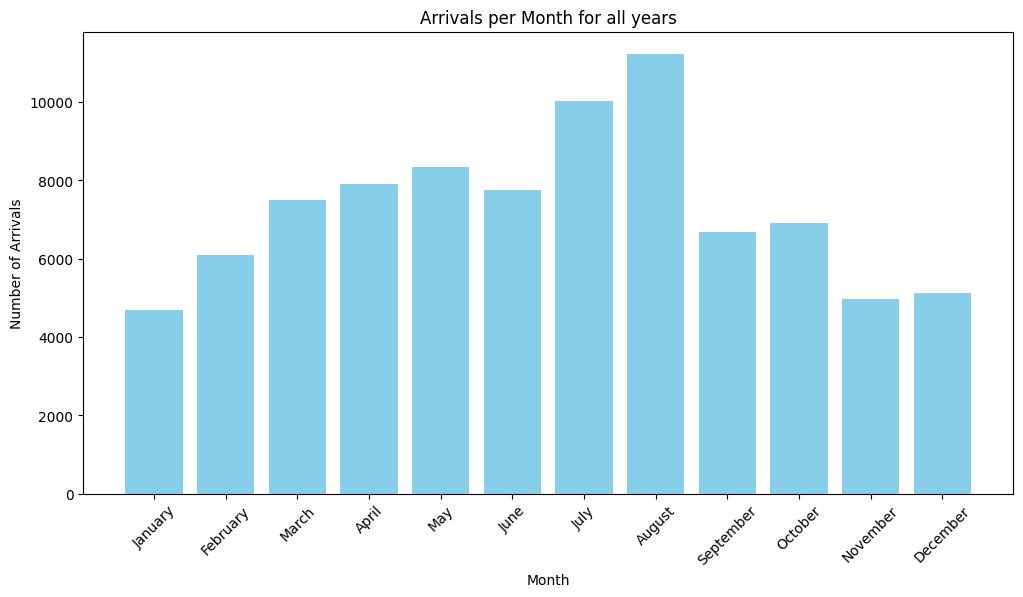

In [139]:
arrival_per_month = df.groupby("ArrivalDateMonth").size()
plt.figure(figsize=(12,6))
plt.bar(arrival_per_month.index, arrival_per_month.values, color='skyblue')

# Set labels and title
plt.xlabel('Month')
plt.ylabel('Number of Arrivals')
plt.title('Arrivals per Month for all years')

# Convert month numbers to month names
month_names = [calendar.month_name[month] for month in arrival_per_month.index]

# Set the x-axis tick labels to be the month names
plt.xticks(arrival_per_month.index, labels=month_names, rotation=45)  # Rotate labels for better readability

# Show plot
plt.show()

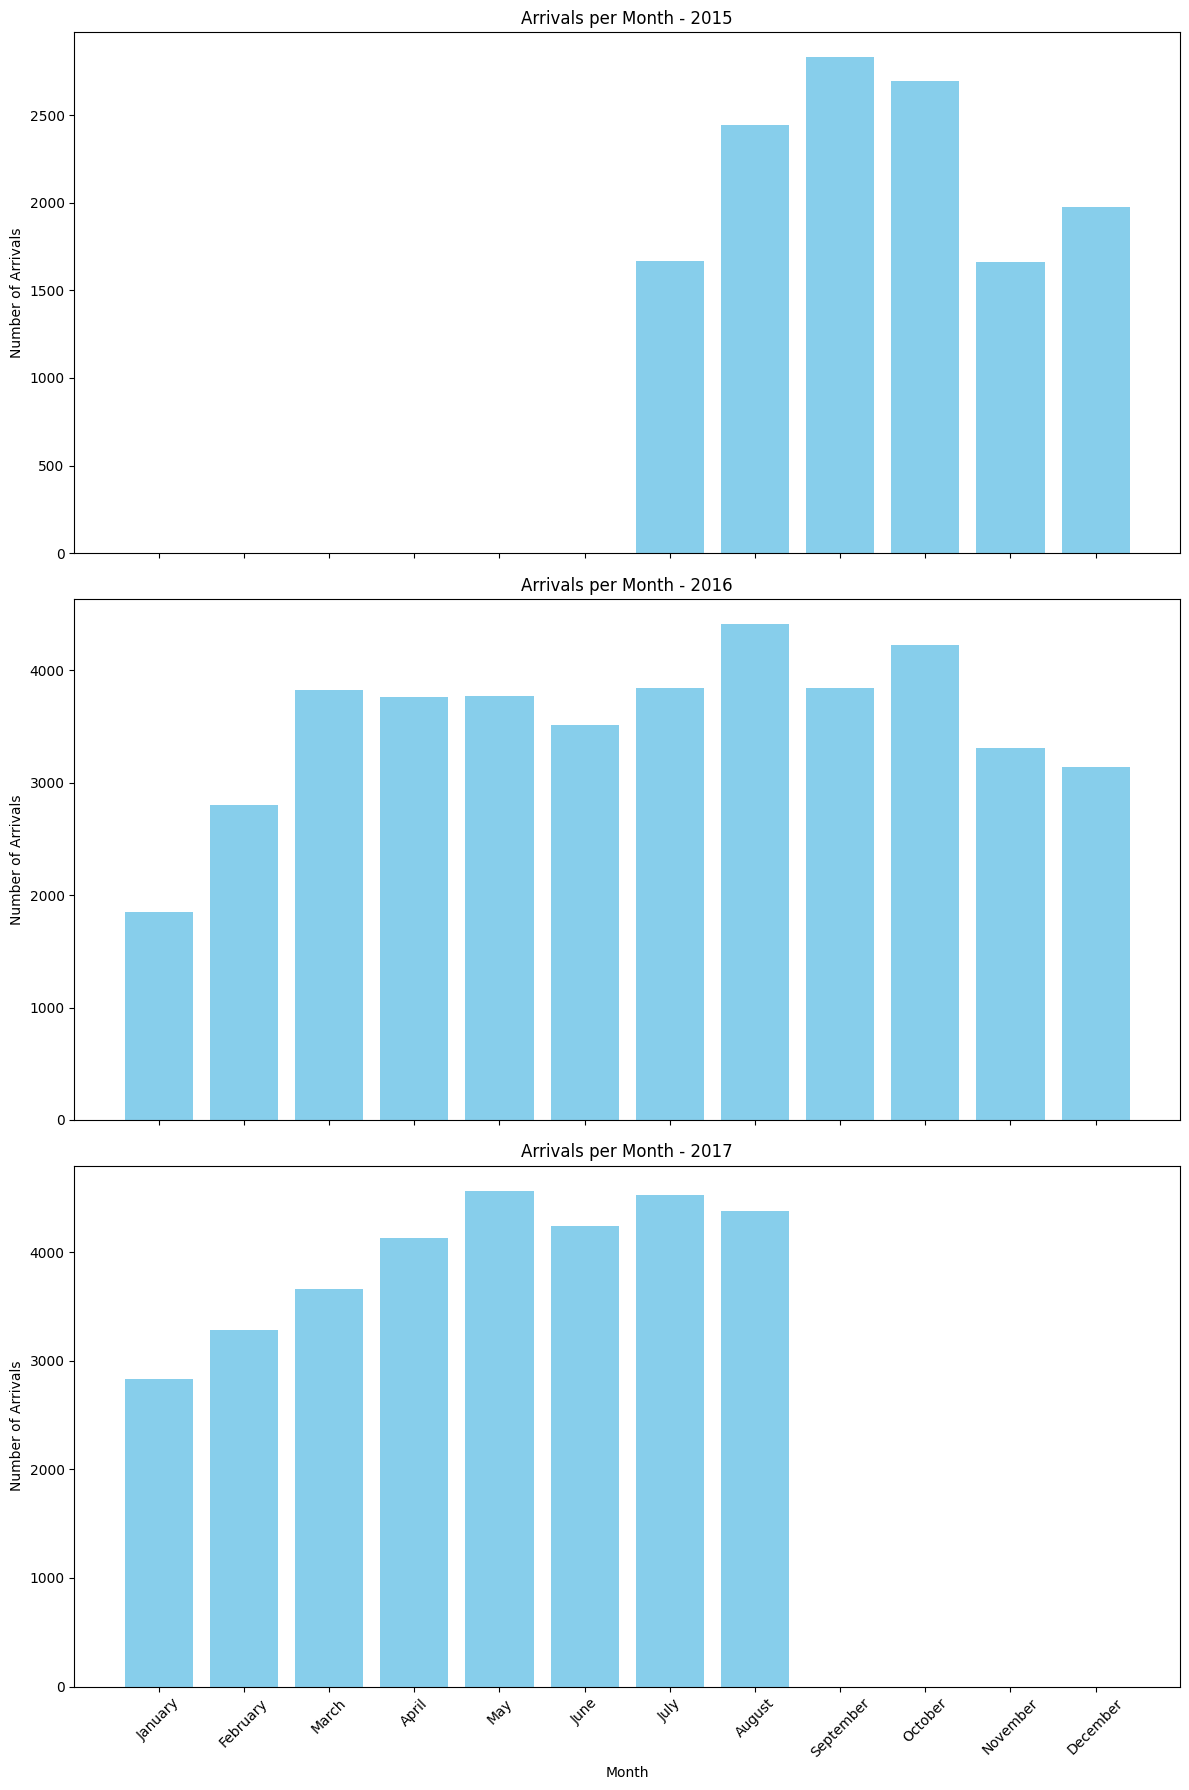

In [140]:
# Assuming df1 is your DataFrame containing the data

# Group the data by year and month and count the number of arrivals
arrivals_per_month_year = df.groupby(["ArrivalDateYear", "ArrivalDateMonth"]).size()

# Get unique years in the data
unique_years = df["ArrivalDateYear"].unique()

# Create subplots for each year
fig, axes = plt.subplots(len(unique_years), 1, figsize=(12, 6 * len(unique_years)), sharex=True)

# Plot arrivals per month for each year
for i, year in enumerate(unique_years):
    # Filter data for the current year
    year_data = arrivals_per_month_year[year]
    # Convert month numbers to month names
    month_names = [calendar.month_name[i] for i in range(1, 13)]  # Months from January to December
    # Get the counts for each month, fill in missing months with 0
    month_counts = [year_data.get(month, 0) for month in range(1, 13)]
    # Plot arrivals per month for the current year in the corresponding subplot
    axes[i].bar(month_names, month_counts, color='skyblue')
    # Set title for the subplot
    axes[i].set_title(f'Arrivals per Month - {year}')
    # Set y-axis label for the subplot
    axes[i].set_ylabel('Number of Arrivals')

# Set common x-axis label for all subplots
plt.xlabel('Month')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent overlapping of subplots
plt.tight_layout()

# Show plot
plt.show()

Text(0.5, 1.0, 'Types of market segment')

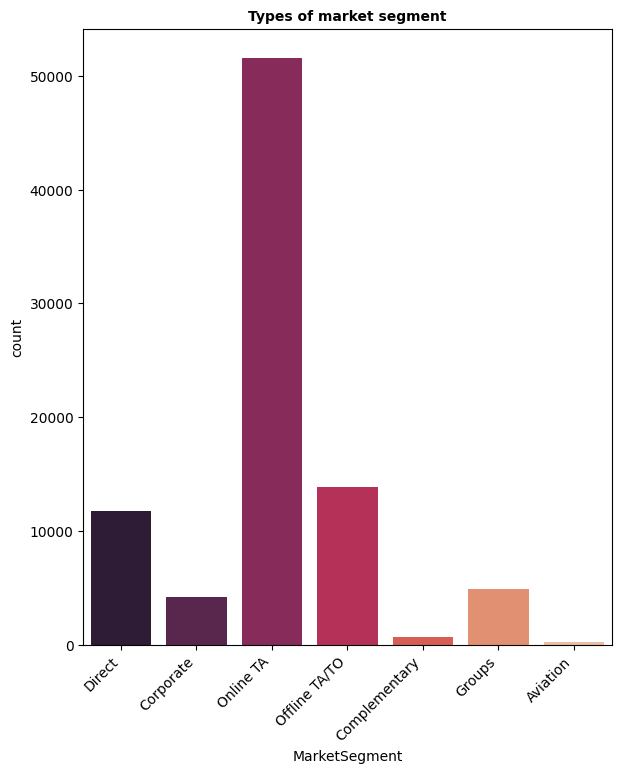

In [141]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
sns.countplot(x='MarketSegment', data=df, palette='rocket')
plt.xticks(rotation=45, ha='right')
plt.title('Types of market segment',fontweight="bold", size=10)

In [142]:
cat_columns = df.select_dtypes(include=['object']).columns
df[cat_columns].head(2)

,Meal,MarketSegment,DistributionChannel,ReservedRoomType,AssignedRoomType,DepositType,CustomerType,ReservationStatus,ReservationStatus_Day
0,BB,Direct,Direct,C,C,No Deposit,Transient,Check-Out,Wednesday
1,BB,Direct,Direct,C,C,No Deposit,Transient,Check-Out,Wednesday


In [143]:
numeric_columns = df.select_dtypes(include=['number']).columns

In [144]:
continuous_columns = []

for column in numeric_columns:
    unique_values = df[column].nunique()
    if unique_values > 12:  # Adjust the threshold as needed
        continuous_columns.append(column)

print("Continuous Columns:", continuous_columns)

Continuous Columns: ['LeadTime', 'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth', 'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'PreviousCancellations', 'PreviousBookingsNotCanceled', 'BookingChanges', 'DaysInWaitingList', 'ADR', 'ReservationStatus_Day_Number']


In [145]:
df.describe().loc[['min', 'max', 'std']]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus_Year,ReservationStatus_Month,ReservationStatus_Day_Number
min,0.000000,0.000000,2015.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-6.3800,0.000000,0.000000,2015.000000,1.000000,1.000000
max,1.000000,737.000000,2017.000000,12.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.00000,72.000000,18.000000,391.000000,5400.0000,8.000000,5.000000,2017.000000,12.000000,31.000000
std,0.446578,86.028979,0.685947,3.096666,13.670105,8.835306,1.027423,2.039961,0.621761,0.456298,0.113713,0.192269,0.36229,1.733171,0.710681,10.001799,54.8905,0.281679,0.832065,0.679827,3.230657,8.793093


From above table we observed that there are few records with negative ADR, which required investigation.

In [146]:
df[(df['ADR'] < 0)  | (df['ADR'] > 1000)]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatus_Year,ReservationStatus_Month,ReservationStatus_Day_Number,ReservationStatus_Day
14969,0,195,2017,3,10,5,4,6,2,0,0,BB,Groups,Direct,1,0,2,A,H,2,No Deposit,0,Transient-Party,-6.38,0,0,Check-Out,2017,3,15,Wednesday
48515,1,35,2016,3,13,25,0,1,2,0,0,BB,Offline TA/TO,TA/TO,0,0,0,A,A,1,Non Refund,0,Transient,5400.00,0,0,Canceled,2016,2,19,Friday


In [147]:
loc = df[(df['ADR'] < 0)  | (df['ADR'] > 1000)].index
df.drop(loc, inplace=True)

In [148]:
df[df['ADR'] >= 500]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatus_Year,ReservationStatus_Month,ReservationStatus_Day_Number,ReservationStatus_Day
15083,0,1,2015,7,29,15,0,1,2,0,0,BB,Corporate,Corporate,1,0,1,A,C,0,No Deposit,0,Transient,508.0,1,0,Check-Out,2015,7,16,Thursday
111403,0,0,2017,5,19,9,0,1,1,0,0,BB,Offline TA/TO,TA/TO,0,0,0,A,G,0,No Deposit,0,Transient,510.0,0,0,Check-Out,2017,5,10,Wednesday


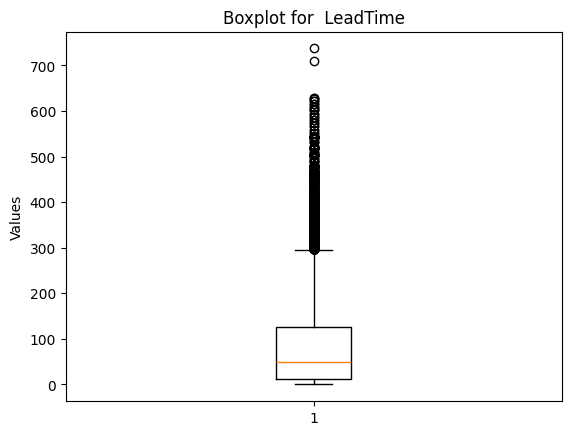

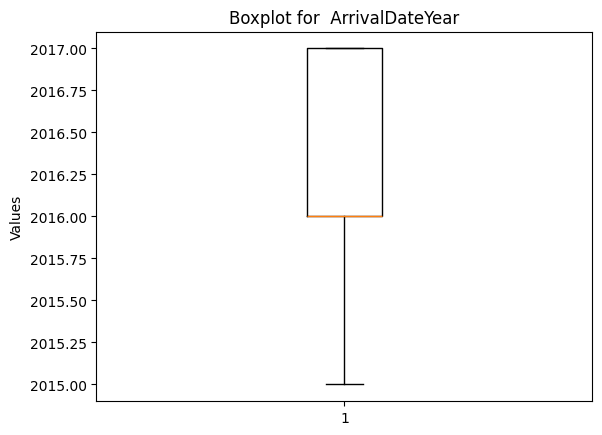

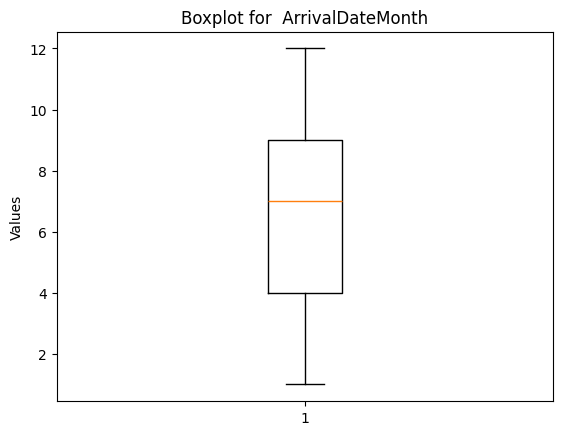

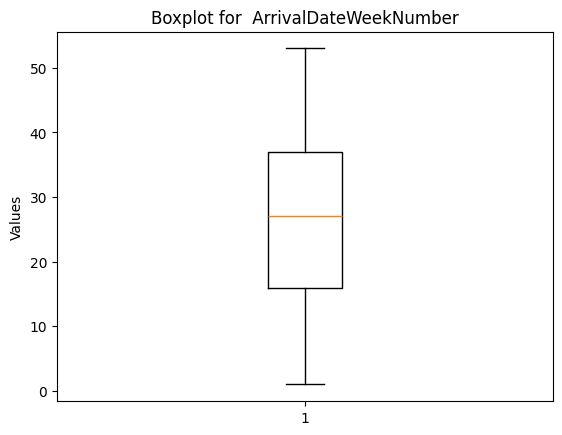

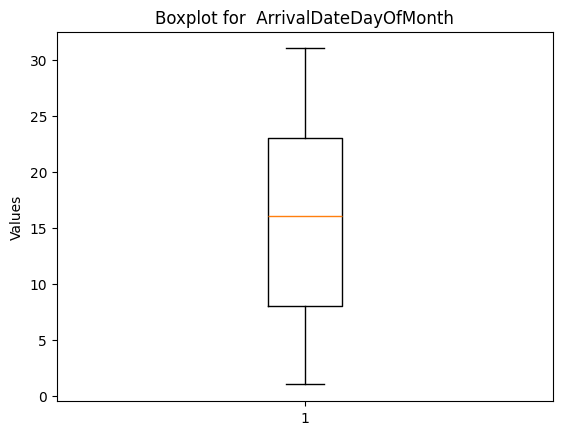

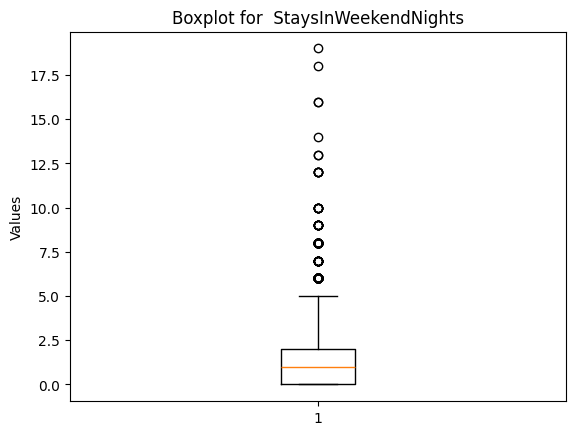

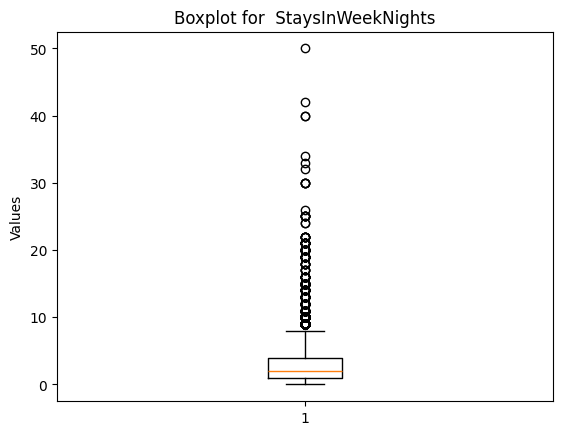

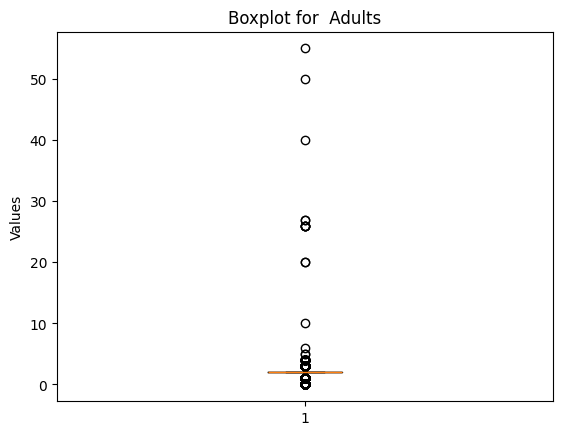

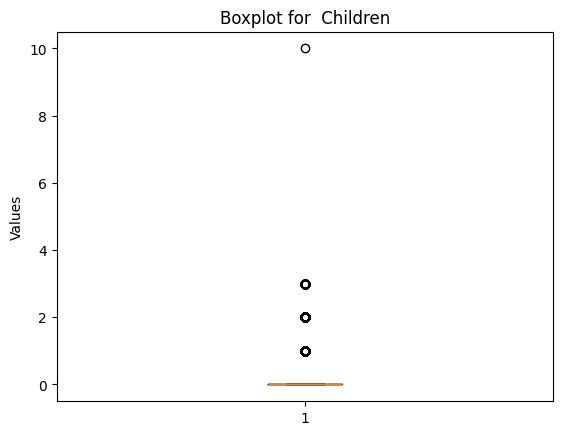

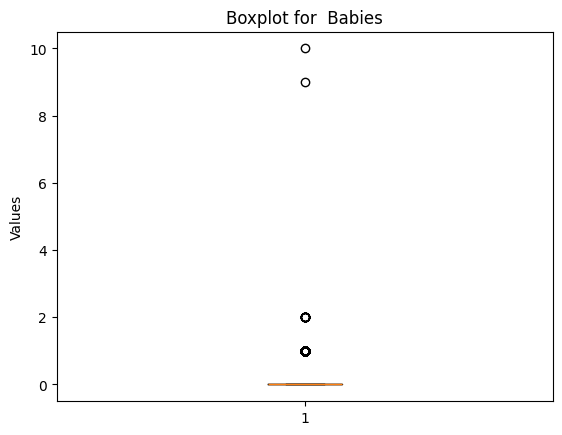

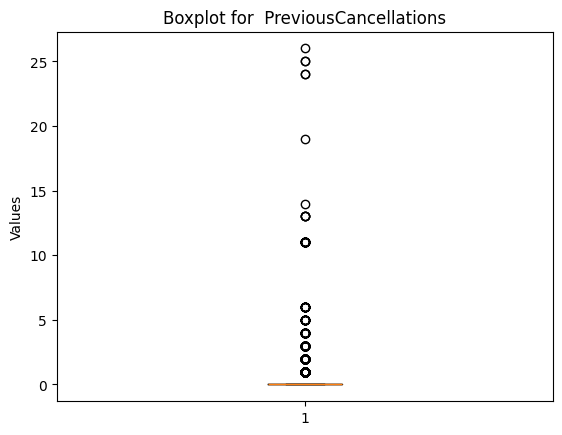

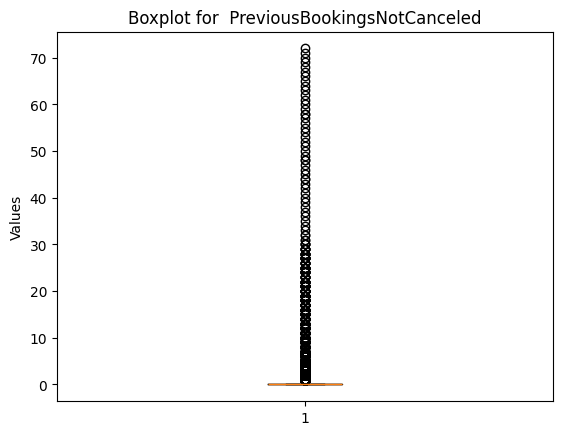

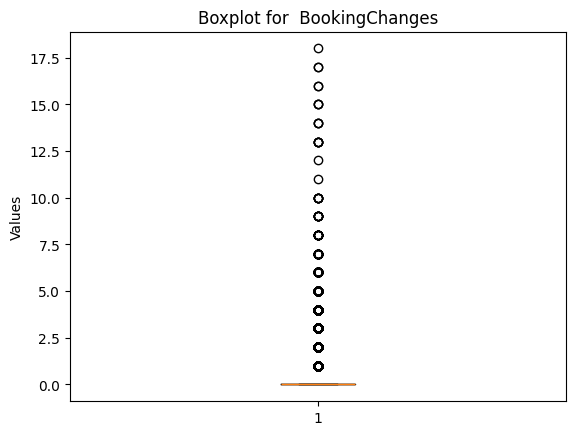

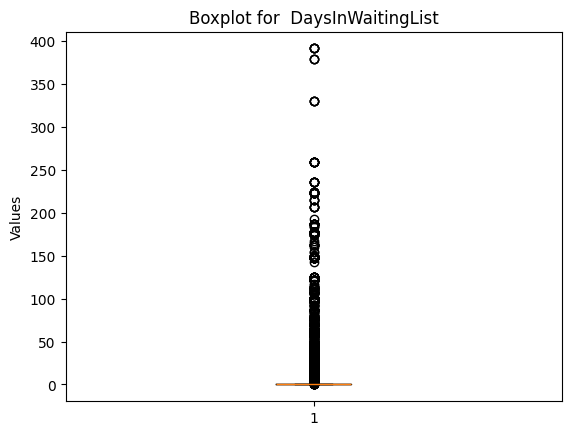

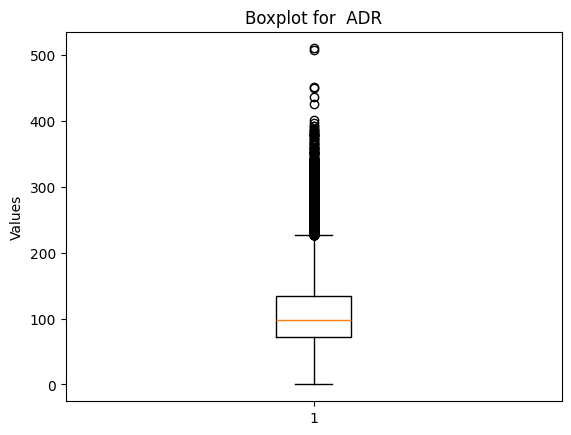

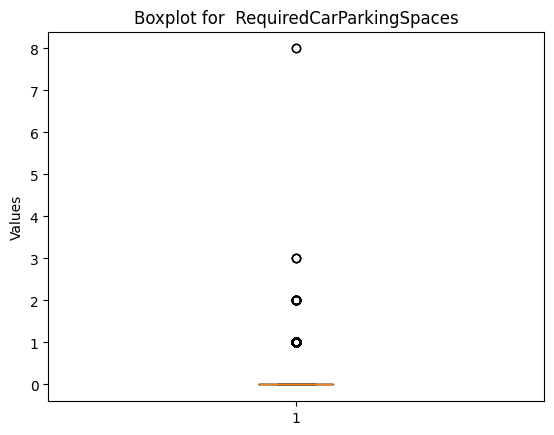

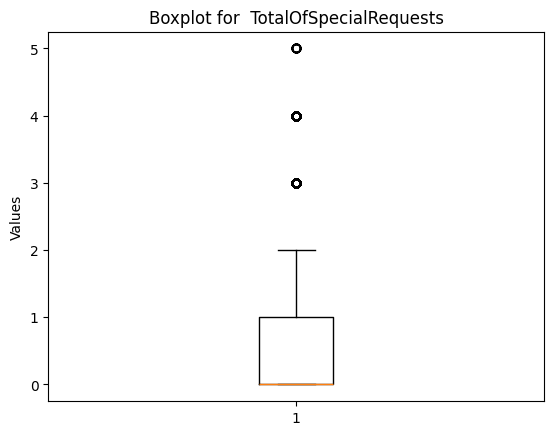

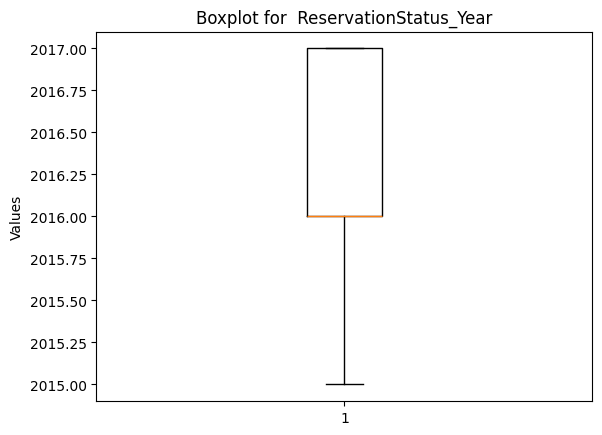

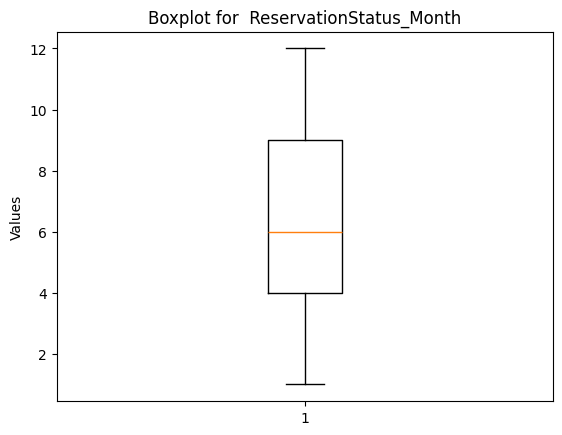

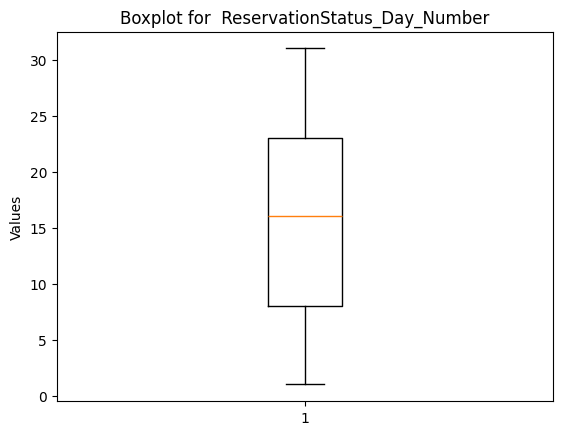

In [149]:
#plot boxplot for numeric columns using IQR method to see the outliers
for column in numeric_columns:
    if df[column].nunique() != 2:
        plt.boxplot(df[column])
        plt.title(f'Boxplot for  {column}')
        plt.ylabel('Values')
        plt.show()

In [150]:
df[df['LeadTime'] > 700]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatus_Year,ReservationStatus_Month,ReservationStatus_Day_Number,ReservationStatus_Day
1,0,737,2015,7,27,1,0,0,2,0,0,BB,Direct,Direct,0,0,0,C,C,4,No Deposit,0,Transient,0.0,0,0,Check-Out,2015,7,1,Wednesday
4182,0,709,2016,2,9,25,8,20,2,0,0,HB,Direct,Direct,0,0,0,E,E,2,No Deposit,0,Transient,68.0,0,0,Check-Out,2016,3,24,Thursday


In [151]:
dummy_df = pd.get_dummies(df[[ 'Meal', 'MarketSegment', 'DistributionChannel', 'ReservedRoomType', 'AssignedRoomType', 'DepositType', 'CustomerType','ReservationStatus']], drop_first=True, dtype=int)
dummy_df.head(2)
df.drop(['Meal', 'MarketSegment', 'DistributionChannel', 'ReservedRoomType', 'AssignedRoomType', 'DepositType', 'CustomerType','ReservationStatus'], axis=1, inplace=True)
df1 = pd.concat([df, dummy_df], axis=1)
df1.drop(['ReservationStatus_Day'], axis=1, inplace=True)
df1.columns

Index(['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth',
       'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
       'Babies', 'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'BookingChanges', 'DaysInWaitingList',
       'ADR', 'RequiredCarParkingSpaces', 'TotalOfSpecialRequests',
       'ReservationStatus_Year', 'ReservationStatus_Month',
       'ReservationStatus_Day_Number', 'Meal_FB', 'Meal_HB', 'Meal_SC',
       'Meal_Undefined', 'MarketSegment_Complementary',
       'MarketSegment_Corporate', 'MarketSegment_Direct',
       'MarketSegment_Groups', 'MarketSegment_Offline TA/TO',
       'MarketSegment_Online TA', 'DistributionChannel_Direct',
       'DistributionChannel_GDS', 'DistributionChannel_TA/TO',
       'DistributionChannel_Undefined', 'ReservedRoomType_B',
       'ReservedRoomType_C', 'ReservedRoomType_D', 'ReservedRoomType_E',
       'ReservedRoomT

In [153]:
len(df1.columns.tolist())

61

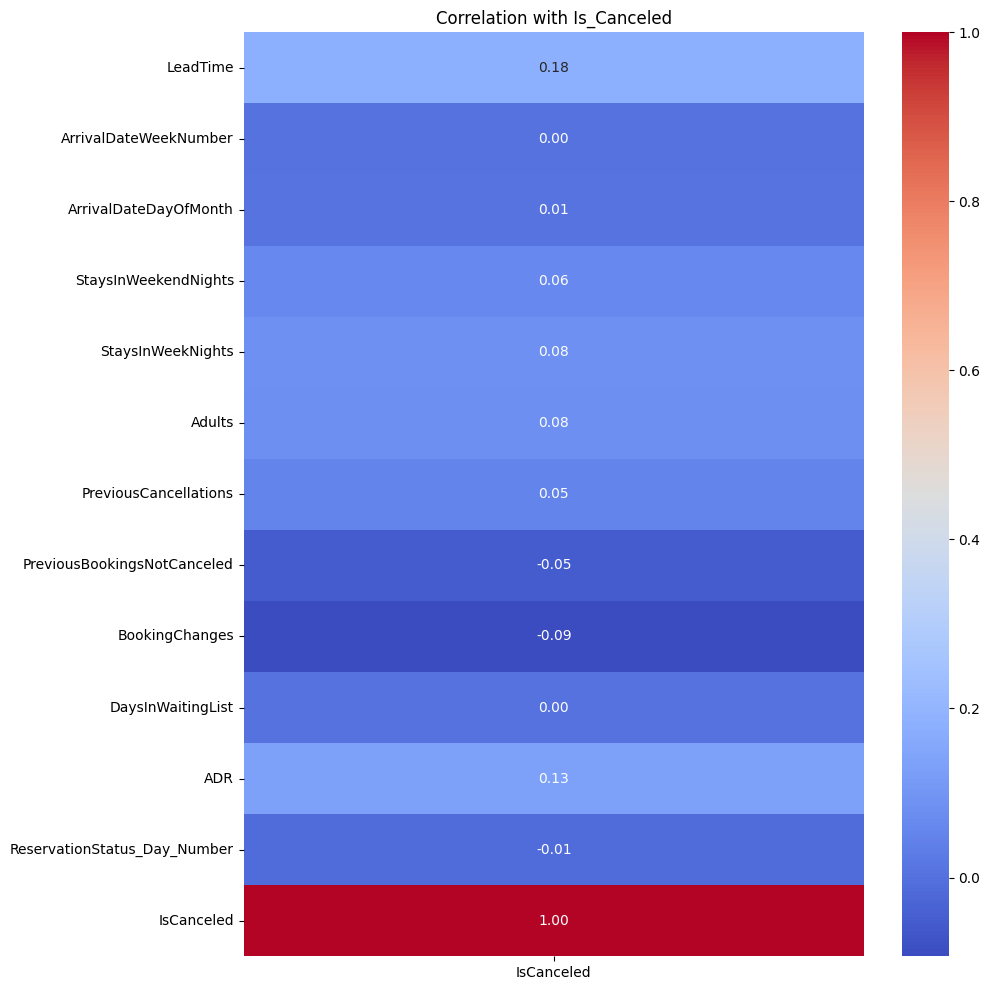

In [154]:
continuous_columns.append('IsCanceled')
corr = df1[continuous_columns].corr()
# Select only the correlation values related to 'Is_Canceled' column
corr_is_canceled = corr['IsCanceled']

# Plot heatmap
plt.figure(figsize=(10, 12))
sns.heatmap(pd.DataFrame(corr_is_canceled), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation with Is_Canceled')
plt.show()

In [155]:
final_col = dummy_df.columns.tolist()
final_col.extend(['LeadTime', 'ADR', 'IsCanceled'])

In [156]:
features = final_col
finaldf = df1[features]

X = finaldf.drop(columns=['IsCanceled'])  # Features
y = finaldf['IsCanceled'] 

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [158]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((61049, 41), (26165, 41), (61049,), (26165,))

In [160]:
X_train.columns
X_train.head(2)

,Meal_FB,Meal_HB,Meal_SC,Meal_Undefined,MarketSegment_Complementary,MarketSegment_Corporate,MarketSegment_Direct,MarketSegment_Groups,MarketSegment_Offline TA/TO,MarketSegment_Online TA,DistributionChannel_Direct,DistributionChannel_GDS,DistributionChannel_TA/TO,DistributionChannel_Undefined,ReservedRoomType_B,ReservedRoomType_C,ReservedRoomType_D,ReservedRoomType_E,ReservedRoomType_F,ReservedRoomType_G,ReservedRoomType_H,ReservedRoomType_L,AssignedRoomType_B,AssignedRoomType_C,AssignedRoomType_D,AssignedRoomType_E,AssignedRoomType_F,AssignedRoomType_G,AssignedRoomType_H,AssignedRoomType_I,AssignedRoomType_K,AssignedRoomType_L,DepositType_Non Refund,DepositType_Refundable,CustomerType_Group,CustomerType_Transient,CustomerType_Transient-Party,ReservationStatus_Check-Out,ReservationStatus_No-Show,LeadTime,ADR
38425,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,212,160.40
12528,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,157,158.57


In [161]:
# Define numeric and categorical features
numeric_features = X.columns

# Create preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

In [162]:
# Define the ANN model
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=1000)

# Define logistic regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1, verbose=1, class_weight='balanced')

# Define SVM model
svm_model = SVC(kernel='linear', C=1, random_state=42, class_weight='balanced', probability=True)

# Define the model architecture with regularization and dropout
seq_reg_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
# Compile the model
seq_reg_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

models = [mlp, logistic_model, svm_model, seq_reg_model]
# models = [seq_model]

In [163]:
def scores(model, X_train,y_train,X_test, y_test):
    print('Model:', model.__class__.__name__)

    if model.__class__.__name__ == 'Sequential':
        # Preprocess the data
        X_train_processed = preprocessor.fit_transform(X_train)
        X_test_processed = preprocessor.transform(X_test)

        epochs = 10
        validation_split = 0.2

        model.fit(X_train_processed, y_train, epochs=epochs, batch_size=32, validation_split=validation_split)

        # Predict on training set
        train_loss, train_accuracy =  model.evaluate(X_train_processed, y_train)
        print('Train score: ', train_accuracy)
        
        # Predict on test set
        test_loss, test_accuracy =  model.evaluate(X_test_processed, y_test)
        print('Test score: ', test_accuracy)

        # Predict on test set
        y_pred = model.predict(X_test_processed)
        y_pred = y_pred > 0.5
        print('Recall Score:', recall_score(y_test, y_pred))

    else:        
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)]) 
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        print('Train Score:', pipeline.score(X_train, y_train))
        print('Test Score:', pipeline.score(X_test, y_test))
        print('Recall Score:', recall_score(y_test, y_pred))
    
    # Assuming y_test contains the true labels and y_pred contains the predicted labels
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plotting the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', 
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    print('Classification Report:', classification_report(y_test, y_pred))
    print('\n\n')

************************************************************************************************************************
Model: MLPClassifier
Train Score: 1.0
Test Score: 0.9999235620103192
Recall Score: 0.9998594716132658


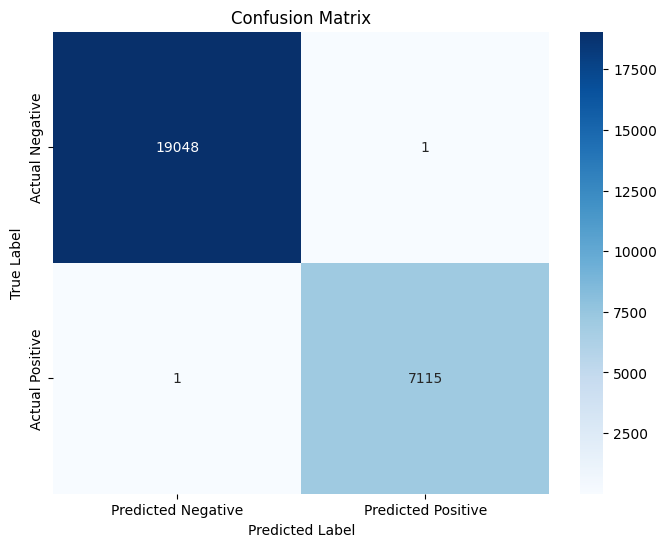

Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19049
           1       1.00      1.00      1.00      7116

    accuracy                           1.00     26165
   macro avg       1.00      1.00      1.00     26165
weighted avg       1.00      1.00      1.00     26165




************************************************************************************************************************
Model: LogisticRegression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Train Score: 1.0
Test Score: 1.0
Recall Score: 1.0


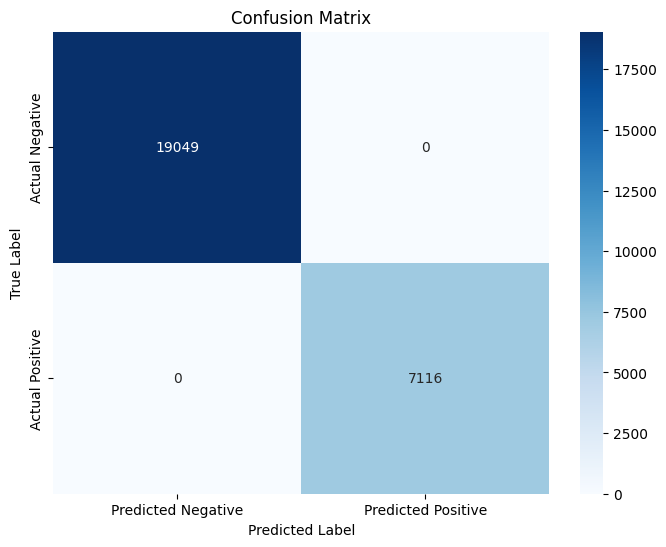

Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19049
           1       1.00      1.00      1.00      7116

    accuracy                           1.00     26165
   macro avg       1.00      1.00      1.00     26165
weighted avg       1.00      1.00      1.00     26165




************************************************************************************************************************
Model: SVC
Train Score: 1.0
Test Score: 1.0
Recall Score: 1.0


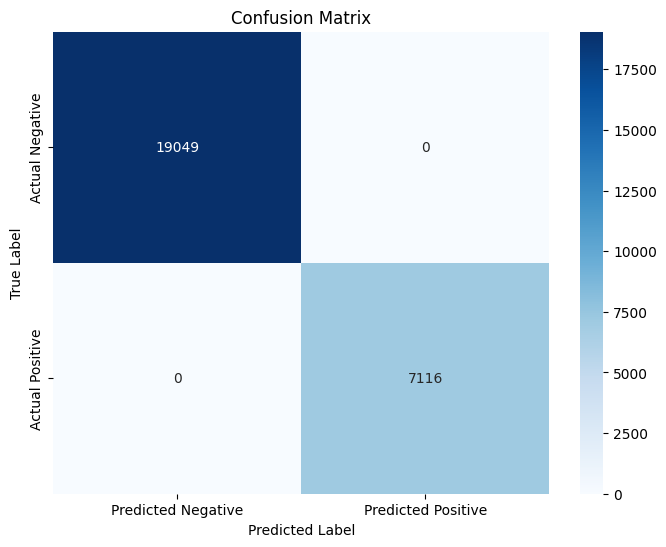

Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19049
           1       1.00      1.00      1.00      7116

    accuracy                           1.00     26165
   macro avg       1.00      1.00      1.00     26165
weighted avg       1.00      1.00      1.00     26165




************************************************************************************************************************
Model: Sequential
Epoch 1/10


1527/1527 [==============================] - 5s 2ms/step - loss: 0.0645 - accuracy: 0.9895 - val_loss: 0.0162 - val_accuracy: 0.9997
Epoch 2/10
1527/1527 [==============================] - 4s 2ms/step - loss: 0.0101 - accuracy: 0.9997 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 3/10
1527/1527 [==============================] - 4s 2ms/step - loss: 0.0055 - accuracy: 0.9998 - val_loss: 0.0093 - val_accuracy: 0.9987
Epoch 4/10
1527/1527 [==============================] - 4s 3ms/step - loss

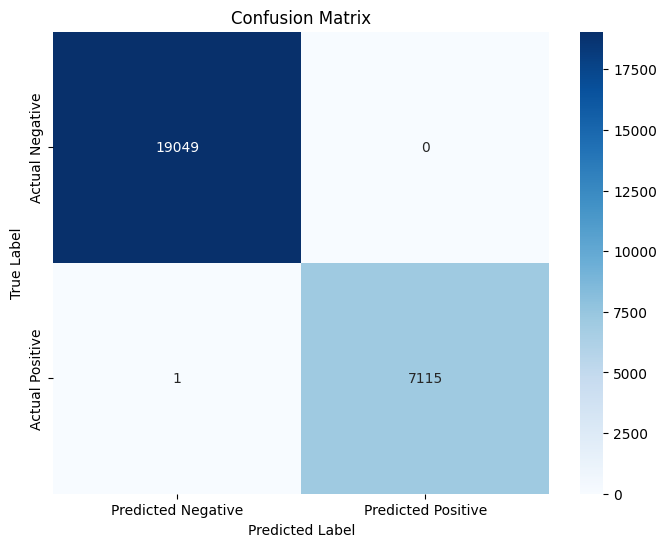

Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19049
           1       1.00      1.00      1.00      7116

    accuracy                           1.00     26165
   macro avg       1.00      1.00      1.00     26165
weighted avg       1.00      1.00      1.00     26165






In [164]:
for model in models:
    print('***'*40)
    scores(model, X_train,y_train,X_test, y_test)

In [165]:
y.value_counts()

IsCanceled
0    63220
1    23994
Name: count, dtype: int64

##### Balancing the dataset using SMOTE-ENN technique

SMOTE-ENN
SMOTE-ENN (Synthetic Minority Over-sampling Technique and Edited Nearest Neighbors) is a combination sampling technique used in machine learning for imbalanced datasets. 
First, SMOTE generates synthetic examples of the minority class to balance the dataset. Then, ENN removes noisy examples from both the minority and majority classes using a k-nearest neighbors algorithm.
By combining these techniques, SMOTE-ENN aims to address class imbalance while also improving the quality of the dataset by removing noisy samples. This can lead to better performance of machine learning models, especially in scenarios where the class distribution is skewed.

In [166]:
# Instantiate SMOTE-ENN
smote_enn = SMOTEENN(random_state=42)

# Apply SMOTE-ENN to generate synthetic samples and remove noisy samples
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

# Convert the resampled data back to a DataFrame
df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='IsCanceled')], axis=1)

df_resampled['IsCanceled'].value_counts()

IsCanceled
1    54538
0    42060
Name: count, dtype: int64

##### Spliting datset into train and test

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

************************************************************************************************************************
Model: MLPClassifier
Train Score: 1.0
Test Score: 1.0
Recall Score: 1.0


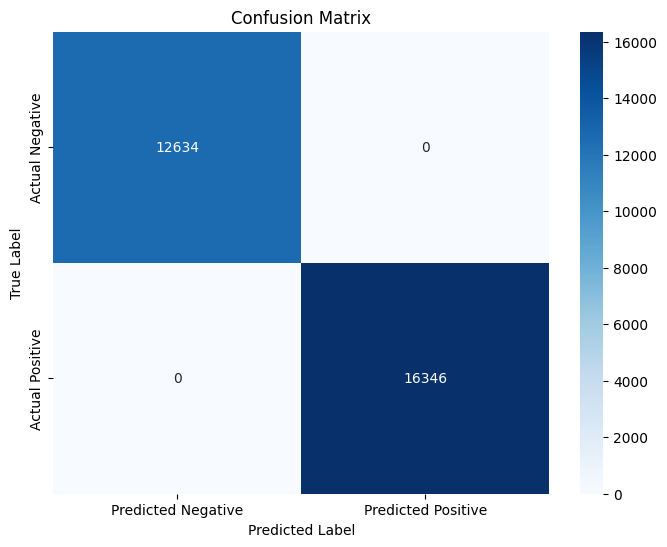

Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     12634
           1       1.00      1.00      1.00     16346

    accuracy                           1.00     28980
   macro avg       1.00      1.00      1.00     28980
weighted avg       1.00      1.00      1.00     28980




************************************************************************************************************************
Model: LogisticRegression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Train Score: 1.0
Test Score: 1.0
Recall Score: 1.0


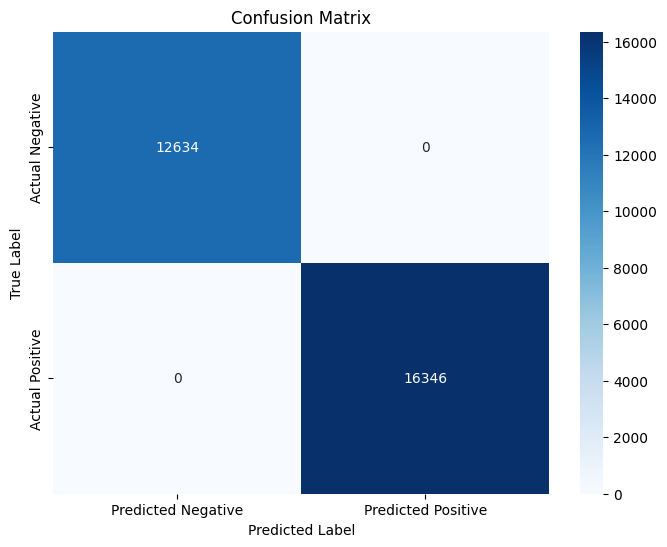

Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     12634
           1       1.00      1.00      1.00     16346

    accuracy                           1.00     28980
   macro avg       1.00      1.00      1.00     28980
weighted avg       1.00      1.00      1.00     28980




************************************************************************************************************************
Model: SVC
Train Score: 1.0
Test Score: 1.0
Recall Score: 1.0


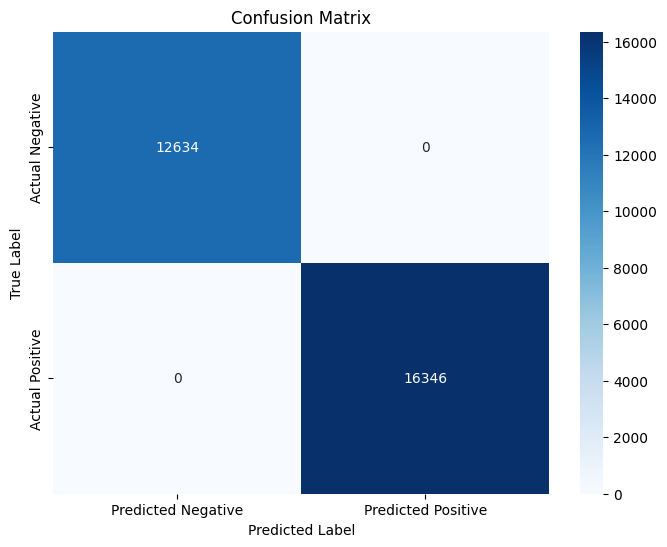

Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     12634
           1       1.00      1.00      1.00     16346

    accuracy                           1.00     28980
   macro avg       1.00      1.00      1.00     28980
weighted avg       1.00      1.00      1.00     28980




************************************************************************************************************************
Model: Sequential
Epoch 1/10
1691/1691 [==============================] - 7s 4ms/step - loss: 0.0038 - accuracy: 0.9997 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 2/10
1691/1691 [==============================] - 5s 3ms/step - loss: 0.0028 - accuracy: 0.9998 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 3/10
1691/1691 [==============================] - 6s 4ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 0.9999
Epoch 4/10
1691/1691 [==============================] - 7s 4ms/step - loss: 

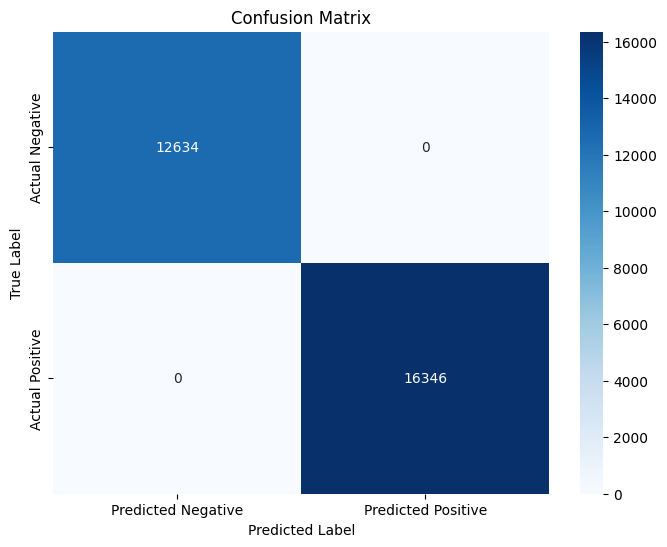

Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     12634
           1       1.00      1.00      1.00     16346

    accuracy                           1.00     28980
   macro avg       1.00      1.00      1.00     28980
weighted avg       1.00      1.00      1.00     28980






In [168]:
for model in models:
    print('***'*40)
    scores(model, X_train,y_train,X_test, y_test)